# Raw staking events to staker activity table Script
This script converts the staking events data returned by [Threshold Network Staking Event Dune query](./ThresholdNetworkStakingEvents.sql) to a table that contains stake activity history.

## Generate atomic stake history
The resulting data contains the historical amount for each stake. Each row contains the general stake status in the moment in which it was updated, i.e the staked, toppedUp or unstaked event was emitted.

In [1]:
import pandas as pd

staking_events = pd.read_csv(
    'StakingEvents2025-01-10.csv', dtype={'amount': str})

staking_events["amount"] = staking_events["amount"].apply(int)

st_prov_list = staking_events.staking_provider.unique().tolist()

atomic_stakes_history = pd.DataFrame(
    index=staking_events.index, columns=['timestamp']+st_prov_list)

for index, row in staking_events.iterrows():
    if index == 0:
        atomic_stakes_history.iloc[index] = 0
        atomic_stakes_history.loc[index, 'timestamp'] = row.timestamp
        atomic_stakes_history.loc[index, row.staking_provider] = row.amount
    else:
        atomic_stakes_history.iloc[index] = atomic_stakes_history.iloc[index - 1]
        atomic_stakes_history.loc[index, 'timestamp'] = row.timestamp
        if row.event == "staked":
            atomic_stakes_history.loc[index, row.staking_provider] = row.amount
        elif row.event == "toppedUp":
            atomic_stakes_history.loc[index,
                                      row.staking_provider] += row.amount
        elif row.event == "unstaked":
            atomic_stakes_history.loc[index,
                                      row.staking_provider] -= row.amount

atomic_stakes_history["timestamp"] = pd.to_datetime(
    atomic_stakes_history["timestamp"])

## Generate stake history in a daily basis
The resulting data contains the general state of stakes for each day since the start of the staking mechanism.

In [2]:
start_date = atomic_stakes_history['timestamp'].iloc[0]
end_date = atomic_stakes_history['timestamp'].iloc[-1]

dates = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

precise_stakes_history = pd.DataFrame(index=dates, columns=st_prov_list)

for index, row in precise_stakes_history.iterrows():
    if index == dates[0]:
        precise_stakes_history.iloc[0] = 0
    else:
        precise_stakes_history.loc[index] = precise_stakes_history.loc[index -
                                                                       pd.Timedelta(days=1)]

        day_events = atomic_stakes_history.loc[(atomic_stakes_history['timestamp'] < index) & (
            atomic_stakes_history['timestamp'] >= index - pd.Timedelta(days=1))]

        if not day_events.empty:
            precise_stakes_history.loc[index] = day_events.iloc[-1]

precise_stakes_history.to_csv('StakesHistory.csv')

## Historical data
Some plots showing the evolution of the stable yield mechanism.

<Axes: title={'center': 'Total Staked Amount'}>

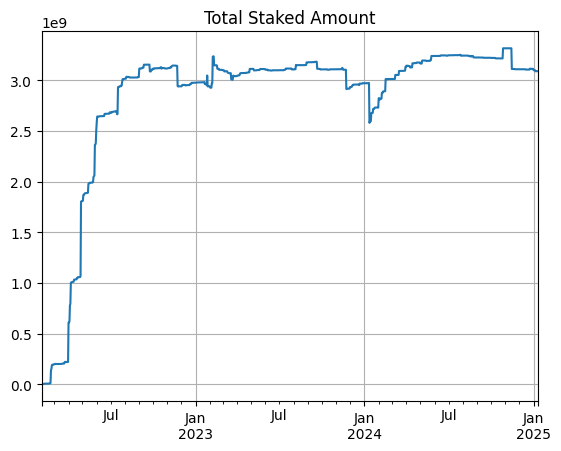

In [3]:
stakes_history = precise_stakes_history.map(
    lambda amount: int(amount/1e18))

stakes_history.sum(axis=1).plot(
    title='Total Staked Amount', grid=True)